<a href="https://colab.research.google.com/github/kylelee417/Asphalt_Crack_Segmentation/blob/master/Asphalt_Segmentation224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Google Drive

In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Import Libraries

In [0]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras


Using TensorFlow backend.


In [0]:
# Generator - Augmentations were already done from another platform -> supervise.ly
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Data Directories

four separate file directories

/Asphalt_Masked/..

                .
                .train_frames/
                .             train/
                .                    img1.png
                .                    img2.png....
                .train_masks/
                .             train/
                .                    img1.png
                .                    img2.png...
                .test_frames/
                .             test/
                .                    img1.png
                .                    img2.png...
                .test_masks/
                             test/
                                    img1.png
                                    img2.png...
                                    

In [0]:
train_ori = '/content/drive/My Drive/Asphalt_Masked/train_frames/'
train_mask = '/content/drive/My Drive/Asphalt_Masked/train_masks/'

test_ori = '/content/drive/My Drive/Asphalt_Masked/test_frames/'
test_mask ='/content/drive/My Drive/Asphalt_Masked/test_masks/'

new_data = '/content/drive/My Drive/Asphalt_Masked/new_data/'

### Hyper-parameters

In [0]:
img_width = 224
img_height = 224
img_channel = 1
input_shape = (img_height,img_width,img_channel)
epochs = 50
batch_size = 32

###Generators for each data

In [0]:
train_ori_generator = train_datagen.flow_from_directory(train_ori,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    color_mode='grayscale',
                                                    shuffle=True,
                                                    seed=0)

train_mask_generator = train_datagen.flow_from_directory(train_mask,
                                                    target_size=(img_width,img_height),
                                                    class_mode=None,
                                                    color_mode='grayscale', 
                                                    batch_size=batch_size, 
                                                    shuffle=True,
                                                    seed=0)

test_ori_generator = test_datagen.flow_from_directory(test_ori,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    color_mode='grayscale',
                                                    shuffle=True,
                                                    seed=0)

test_mask_generator = test_datagen.flow_from_directory(test_mask,
                                                    target_size=(img_width,img_height),
                                                    class_mode=None,
                                                    color_mode='grayscale', 
                                                    batch_size=batch_size, 
                                                    shuffle=True,
                                                    seed=0)

new_generator = test_datagen.flow_from_directory(new_data,
                                                    target_size=(img_width,img_height),
                                                    class_mode=None,
                                                    color_mode='grayscale', 
                                                    batch_size=batch_size, 
                                                    shuffle=False,
                                                    seed=0)



Found 1920 images belonging to 1 classes.
Found 1920 images belonging to 1 classes.
Found 480 images belonging to 1 classes.
Found 480 images belonging to 1 classes.
Found 5 images belonging to 1 classes.


In [0]:
# create generators using zip() that will train orginal and masked images 
train_generator = zip(train_ori_generator,train_mask_generator)
test_generator = zip(test_ori_generator,test_mask_generator)

In [0]:
def unet_build():
    
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])


    return model

In [0]:
m = unet_build()
m.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 64) 36928       conv2d_1[0][0]                   
_________________________________________________________________________

In [0]:
hist = m.fit_generator(train_generator, epochs=epochs, 
                       steps_per_epoch=3840//batch_size, 
                       validation_data = test_generator, 
                       validation_steps = 960//batch_size, 
                       verbose=1)

Epoch 1/50
  7/120 [>.............................] - ETA: 50:27 - loss: 0.3515 - acc: 0.9343

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


120/120 [==============================] - 2194s 18s/step - loss: 0.2141 - acc: 0.9332 - val_loss: 0.2073 - val_acc: 0.9539
Epoch 2/50
120/120 [==============================] - 461s 4s/step - loss: 0.1616 - acc: 0.9332 - val_loss: 0.1790 - val_acc: 0.9539
Epoch 3/50
120/120 [==============================] - 461s 4s/step - loss: 0.1426 - acc: 0.9459 - val_loss: 0.2008 - val_acc: 0.9547
Epoch 4/50
120/120 [==============================] - 464s 4s/step - loss: 0.1310 - acc: 0.9502 - val_loss: 0.2403 - val_acc: 0.9548
Epoch 5/50
120/120 [==============================] - 464s 4s/step - loss: 0.1207 - acc: 0.9529 - val_loss: 0.2194 - val_acc: 0.9544
Epoch 6/50
120/120 [==============================] - 464s 4s/step - loss: 0.1127 - acc: 0.9554 - val_loss: 0.2116 - val_acc: 0.9555
Epoch 7/50
120/120 [==============================] - 465s 4s/step - loss: 0.1072 - acc: 0.9576 - val_loss: 0.3112 - val_acc: 0.9558
Epoch 8/50
120/120 [==============================] - 465s 4s/step - loss: 0.1

### Loss and Accuracy Plots

In [0]:
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
    acc = [hist.history['acc'],hist.history['val_acc']]
    
    fig, axes = plt.subplots(1,2,figsize = (15,3))
    fig.suptitle(model_name)
    for ax,val,name in zip(axes,(loss,acc),['loss','accuracy']):
        ax.plot(val[0], color='b', label="Training")
        ax.plot(val[1], color='r', label="Validation")
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

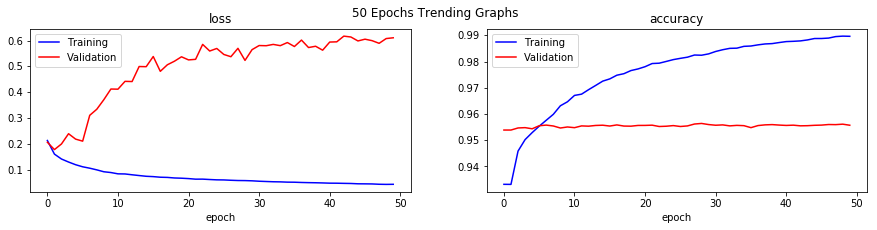

In [0]:
training_plot(hist, '50 Epochs Trending Graphs')

### Prediction with new images

In [0]:
new_input = m.predict_generator(new_generator, steps=new_generator.n, verbose=1)

5/5 [==============================] - 6s 1s/step


In [0]:
X_new = new_generator.next()


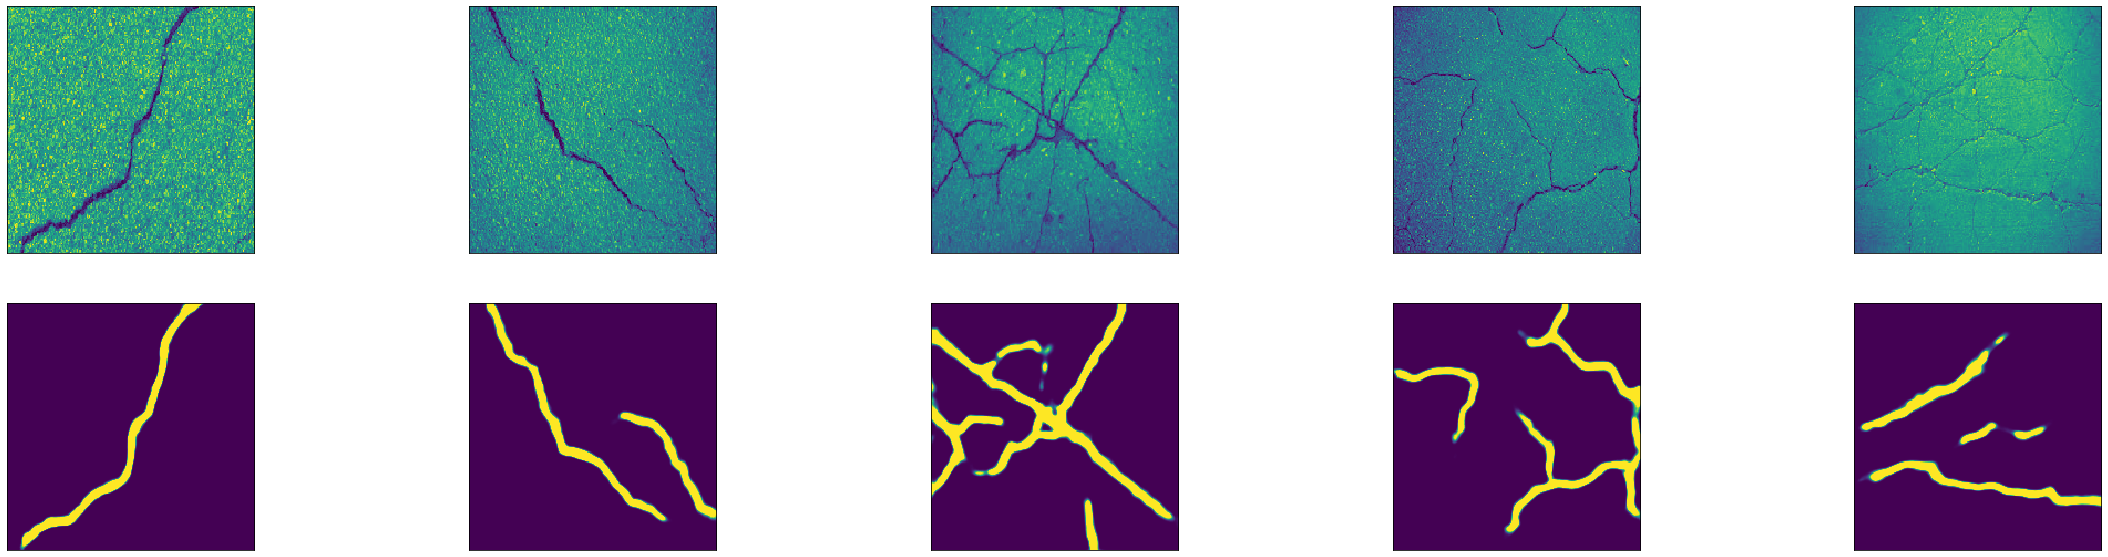

In [0]:

n = 5# # of images will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_new[i].reshape(224,224))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display masked images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(new_input[i].reshape(224,224))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()